In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed-without-outliers.csv"
d = pd.read_csv(datafilename)
print("Loading", len(d), "lines of data (outliers removed).")

resultsfilename = "data_stats-without-outliers.csv"
st = pd.read_csv(resultsfilename)
print("Loading", len(st), "lines of stats.")

# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]
                                 ), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

Loading 14520 lines of data (outliers removed).
Loading 808 lines of stats.


In [2]:
# comparison by design expertise

types = ["lexical", "recognition"]
fonts = ["arial", "sansforgetica"]
skills = ["Designer", "Non-designer"]
metrics = ["Response time", "Response time (word)", "Response time (non-word)", "AUC", "AUC (word)", "AUC (non-word)"]
RTs = metrics[:3]
AUCs = metrics[3:]

cols = pd.MultiIndex.from_product([skills, metrics, ["mean", "SEM"]], names=["skill", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for skill in skills:
        if skill == "Designer":
            r = st[st["isDesigner"] & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        else:
            r = st[(st["isDesigner"] == False) & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (skill, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (skill, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-design-expertise.csv")

skill                              Designer                                \
metric                        Response time          Response time (word)   
stat                                   mean      SEM                 mean   
sid type        font                                                        
1   lexical     arial               2488.91  102.594              1678.88   
                sansforgetica       2774.13  140.597              1930.02   
    recognition arial               2454.94  115.525              2297.41   
                sansforgetica        2588.1  120.122              2408.27   
2   lexical     arial               2535.68  146.869              1849.18   
                sansforgetica       2996.15  155.177              2046.71   
    recognition arial               2538.25   109.38              2340.88   
                sansforgetica       2649.75   104.86              2373.57   

skill                                                                     \
metric                                 Response time (non-word)            
stat                               SEM                     mean      SEM   
sid type        font                                                       
1   lexical     arial          52.1944                   3315.6  183.735   
                sansforgetica  81.0032                  3748.26   315.78   
    recognition arial           104.78                  2612.47  153.811   
                sansforgetica  107.694                  2767.94  159.232   
2   lexical     arial          96.6757                  3226.54  240.248   
                sansforgetica  96.6929                  3984.92  263.987   
    recognition arial          99.5988                  2735.63  150.692   
                sansforgetica  98.4016                   2925.7  156.337   

skill                                                                      \
metric                              AUC             AUC (word)              
stat                               mean         SEM       mean        SEM   
sid type        font                                                        
1   lexical     arial          0.972526  0.00654796        NaN        NaN   
                sansforgetica  0.979423  0.00527942        NaN        NaN   
    recognition arial          0.896521   0.0146142   0.880307   0.018187   
                sansforgetica  0.890478   0.0161991   0.870283  0.0213533   
2   lexical     arial          0.941921   0.0139665        NaN        NaN   
                sansforgetica  0.924924   0.0162821        NaN        NaN   
    recognition arial          0.837129   0.0179227   0.845339  0.0221348   
                sansforgetica  0.844809   0.0181193   0.861758  0.0200908   

skill                            ...             Non-designer           \
metric                           ...     Response time (word)            
stat                             ...                     mean      SEM   
sid type        font             ...                                     
1   lexical     arial            ...                  2154.98  130.863   
                sansforgetica    ...                  2378.54  154.536   
    recognition arial            ...                  2815.68  152.576   
                sansforgetica    ...                  2679.59  113.896   
2   lexical     arial            ...                  1934.92  100.845   
                sansforgetica    ...                  2095.47  85.8405   
    recognition arial            ...                  2475.98  96.0664   
                sansforgetica    ...                  2672.86  108.273   

skill                                                                      \
metric                        Response time (non-word)                AUC   
stat                                              mean      SEM      mean   
sid type        font                                                        
1   lexical     arial                   

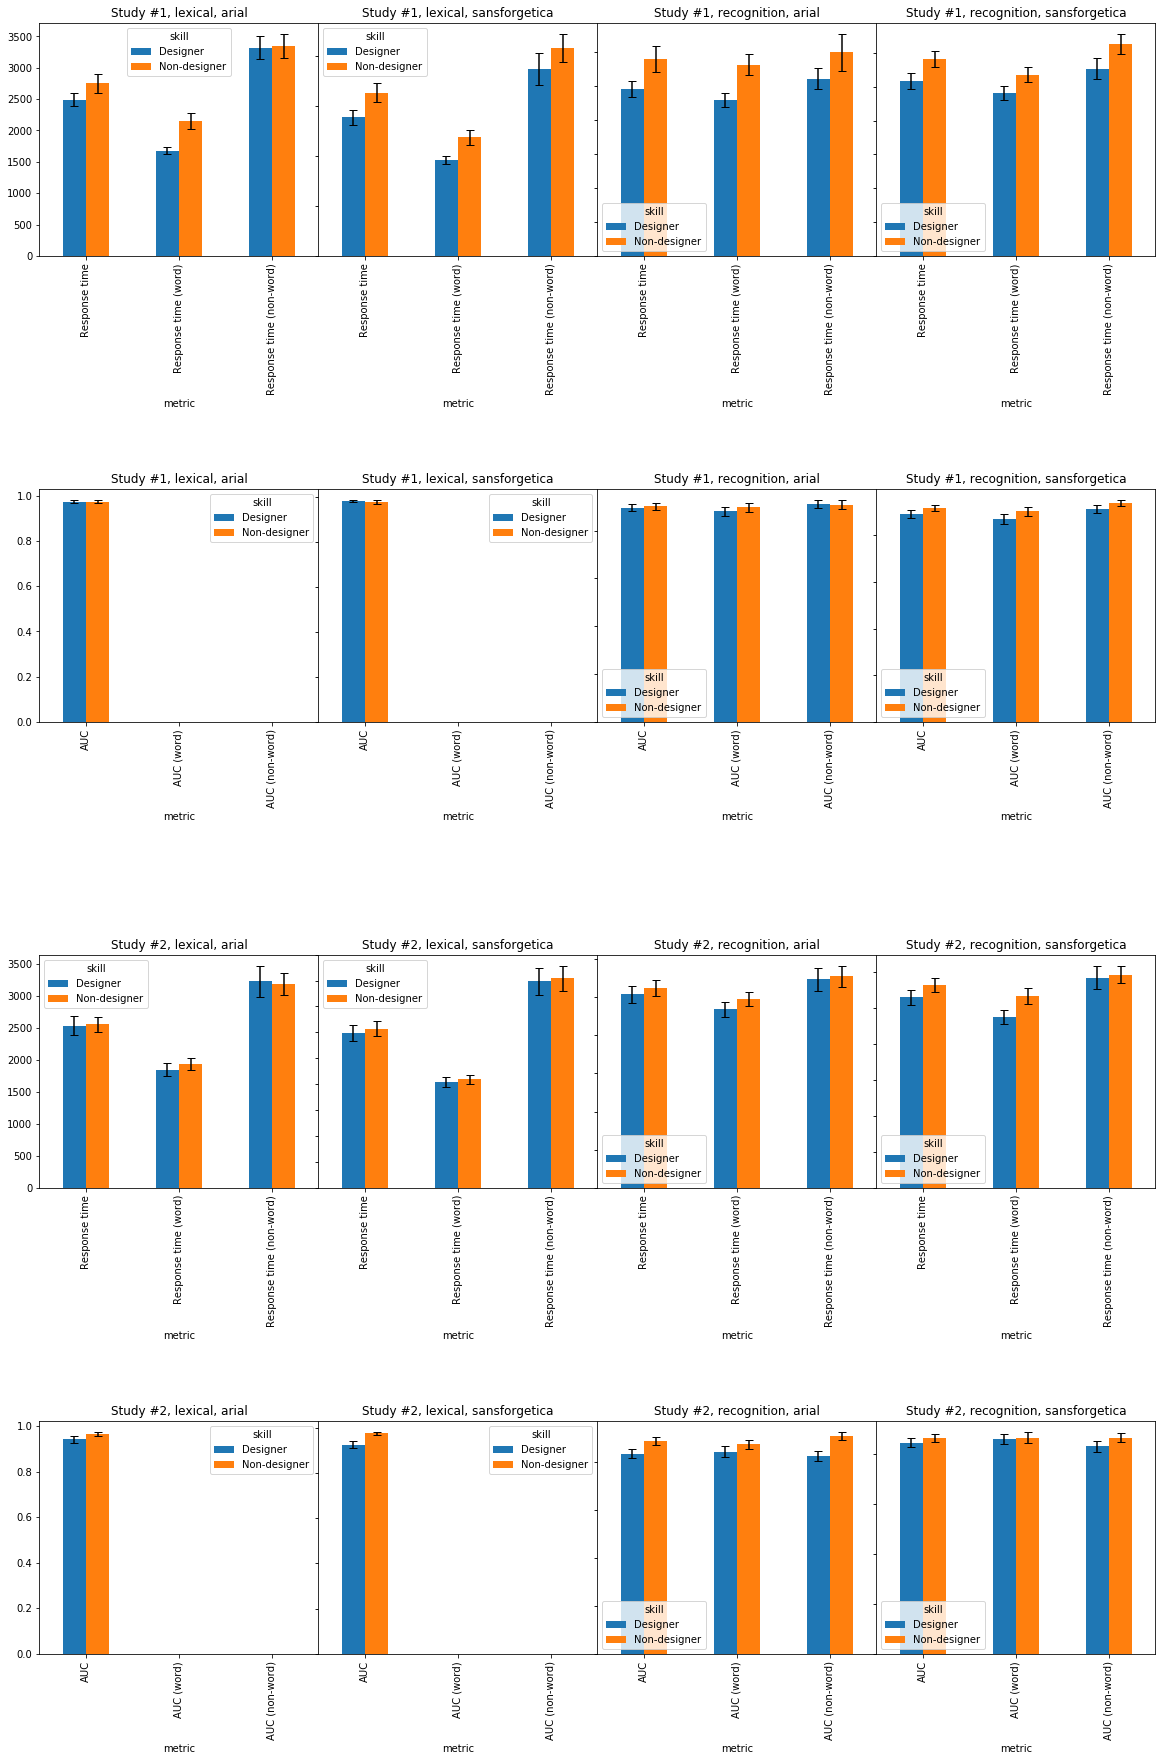

In [3]:
# comparison by design expertise - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-design-expertise.pdf")

In [4]:
# comparison by order

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order.csv")

order                                     1                                \
metric                        Response time          Response time (word)   
stat                                   mean      SEM                 mean   
sid type        font                                                        
1   lexical     arial               2607.31  87.2881              1894.84   
                sansforgetica       2998.04   117.24              2133.47   
    recognition arial                   NaN      NaN                  NaN   
                sansforgetica           NaN      NaN                  NaN   
2   lexical     arial               2611.08  150.699               1953.9   
                sansforgetica       3204.78  139.071              2120.38   
    recognition arial               2552.65  121.227              2393.45   
                sansforgetica        2558.9  77.3495              2364.02   

order                                                                     \
metric                                 Response time (non-word)            
stat                               SEM                     mean      SEM   
sid type        font                                                       
1   lexical     arial          69.7922                  3328.89  131.758   
                sansforgetica  85.5192                   3937.9   213.83   
    recognition arial              NaN                      NaN      NaN   
                sansforgetica      NaN                      NaN      NaN   
2   lexical     arial          101.332                  3268.34  254.733   
                sansforgetica  93.6438                     4296  210.174   
    recognition arial          108.457                  2711.84  168.451   
                sansforgetica  97.2278                  2753.52   95.897   

order                                                                     \
metric                              AUC             AUC (word)             
stat                               mean         SEM       mean       SEM   
sid type        font                                                       
1   lexical     arial          0.972824  0.00480707        NaN       NaN   
                sansforgetica  0.977417   0.0045736        NaN       NaN   
    recognition arial               NaN         NaN        NaN       NaN   
                sansforgetica       NaN         NaN        NaN       NaN   
2   lexical     arial          0.942658   0.0161518        NaN       NaN   
                sansforgetica   0.95662  0.00893899        NaN       NaN   
    recognition arial          0.843597   0.0176634   0.843137  0.021677   
                sansforgetica  0.825666   0.0166221   0.828125  0.020214   

order                            ...                        2           \
metric                           ...     Response time (word)            
stat                             ...                     mean      SEM   
sid type        font             ...                                     
1   lexical     arial            ...                      NaN      NaN   
                sansforgetica    ...                      NaN      NaN   
    recognition arial            ...                   2532.5  93.1272   
                sansforgetica    ...                  2531.34  79.1093   
2   lexical     arial            ...                  1823.32  96.3935   
                sansforgetica    ...                  2012.68  92.6873   
    recognition arial            ...                  2406.31   90.656   
                sansforgetica    ...                  2653.63  109.297   

order                                                                      \
metric                        Response time (non-word)                AUC   
stat                                              mean      SEM      mean   
sid type        font                                                        
1   lexical     arial                              N

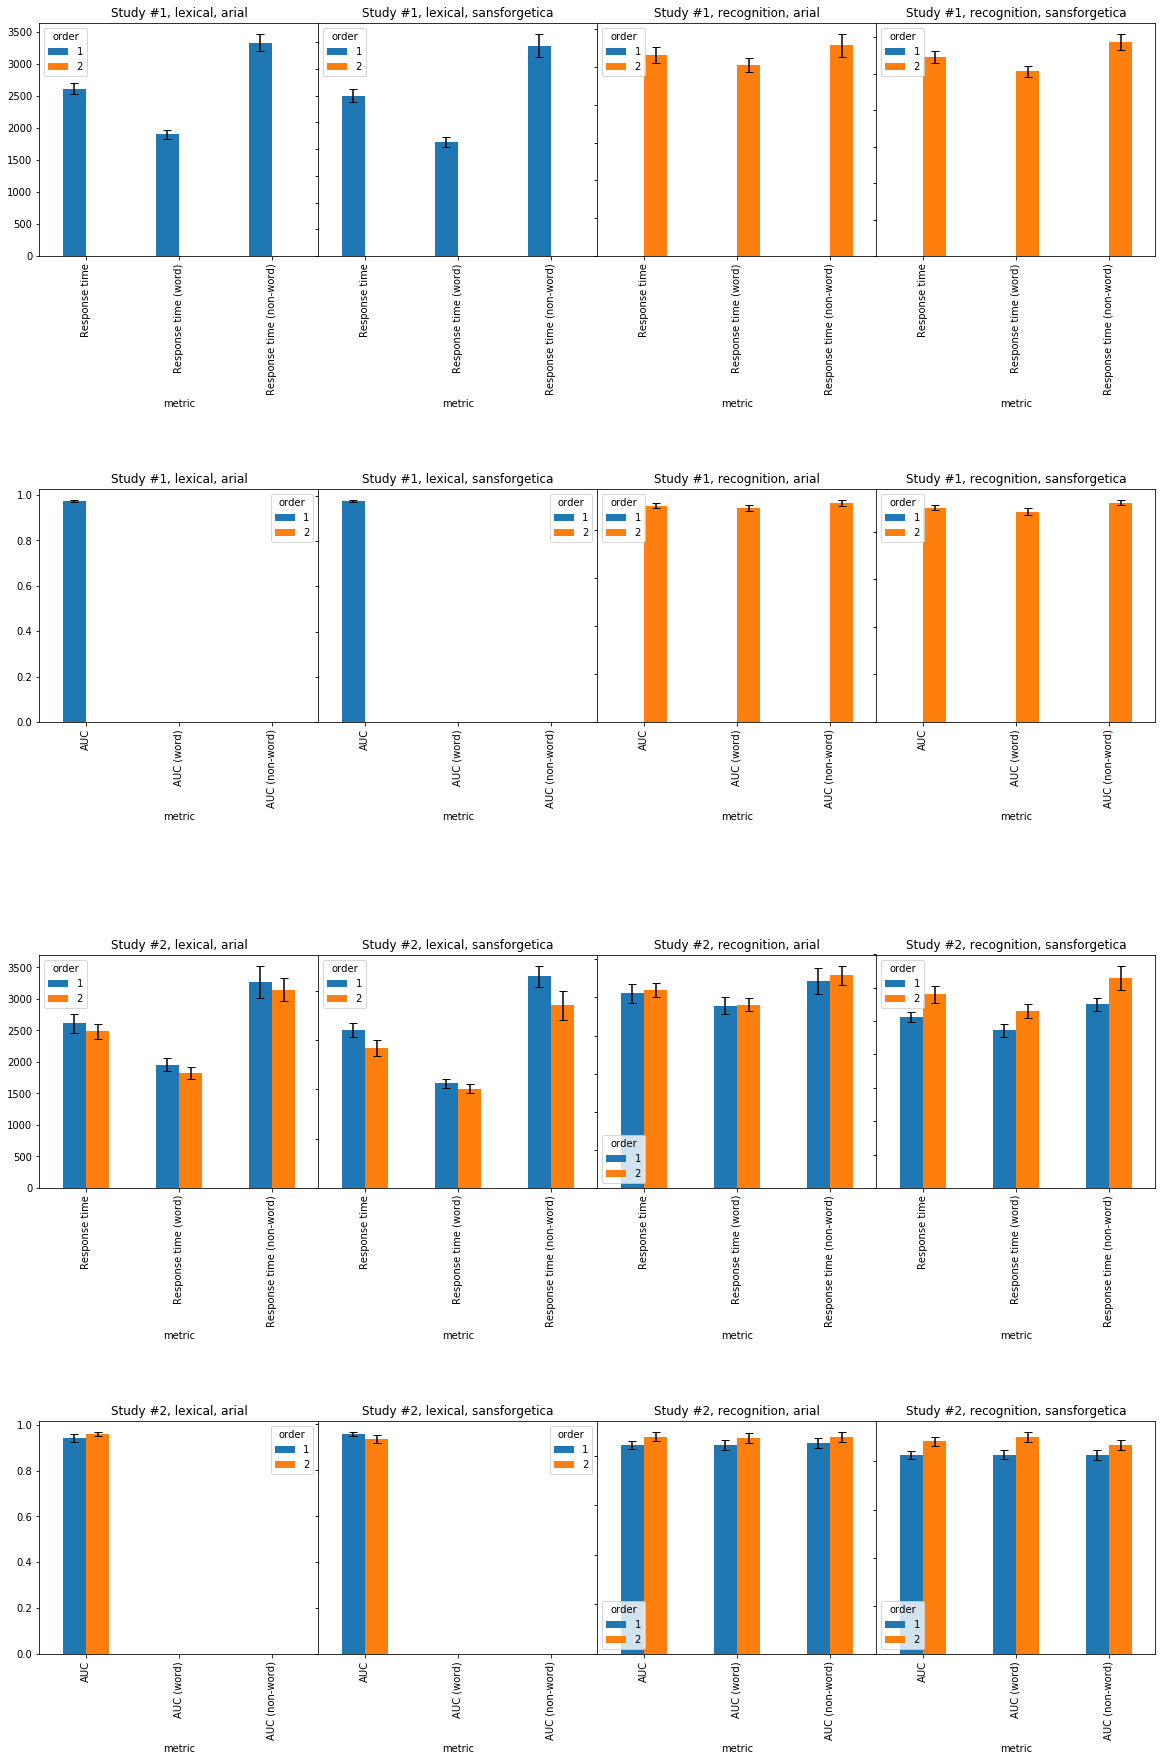

In [5]:
# comparison by order - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-order.pdf")

In [6]:
# comparison by order (simpler)

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types], names=["sid", "type"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order_simpler.csv")

order                       1                                         \
metric          Response time          Response time (word)            
stat                     mean      SEM                 mean      SEM   
sid type                                                               
1   lexical           2802.68  74.2375              2014.16  55.7144   
    recognition           NaN      NaN                  NaN      NaN   
2   lexical           2916.41  105.919              2039.52  69.0121   
    recognition       2555.86  70.7099              2378.32  72.2945   

order                                                                    \
metric          Response time (non-word)                AUC               
stat                                mean      SEM      mean         SEM   
sid type                                                                  
1   lexical                      3633.39   127.16   0.97512  0.00331311   
    recognition                      NaN      NaN       NaN         NaN   
2   lexical                      3796.85  171.074  0.949839  0.00907363   
    recognition                  2733.28   95.082  0.834375   0.0120848   

order                                    ...                        2  \
metric          AUC (word)               ...     Response time (word)   
stat                  mean        SEM    ...                     mean   
sid type                                 ...                            
1   lexical            NaN        NaN    ...                      NaN   
    recognition        NaN        NaN    ...                  2531.92   
2   lexical            NaN        NaN    ...                  1915.29   
    recognition   0.835417  0.0147431    ...                  2526.44   

order                                                                 \
metric                   Response time (non-word)                AUC   
stat                 SEM                     mean      SEM      mean   
sid type                                                               
1   lexical          NaN                      NaN      NaN       NaN   
    recognition  60.9377                  2860.26  92.5757  0.900532   
2   lexical      67.2867                  3419.38  171.664  0.949055   
    recognition  71.3473                  2961.78  109.705   0.88006   

order                                                                         
metric                      AUC (word)             AUC (non-word)             
stat                    SEM       mean         SEM           mean        SEM  
sid type                                                                      
1   lexical             NaN        NaN         NaN            NaN        NaN  
    recognition  0.00744519   0.886598  0.00971855       0.916559  0.0084643  
2   lexical      0.00978618        NaN         NaN            NaN        NaN  
    recognition   0.0128438   0.886607   0.0148639       0.872024  0.0148354  

[4 rows x 24 columns]

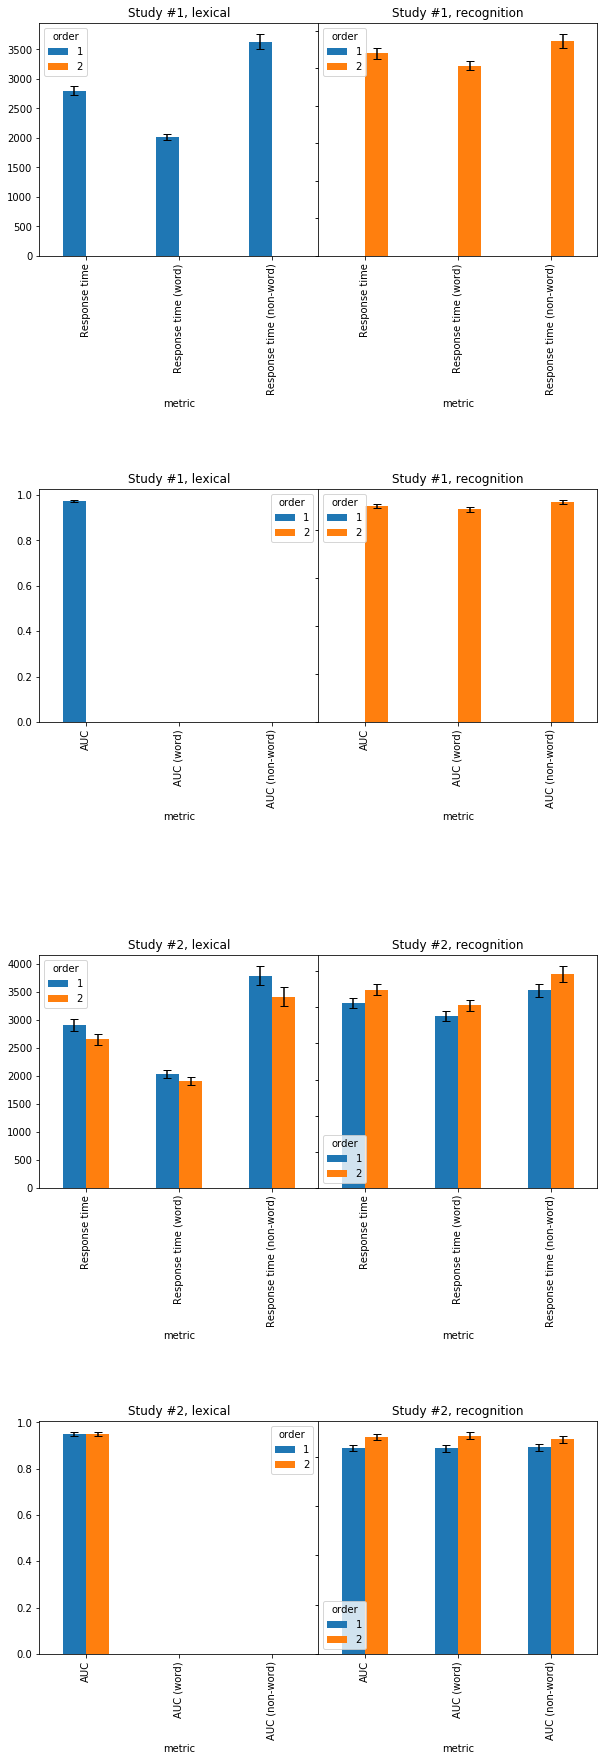

In [7]:
# comparison by order (simpler) - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 2, figsize=(10, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

for sid in [1, 2]:
    for i, t in enumerate(types):
        line = (sid - 1) * 2
        combo = (sid, t)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
fig.savefig("results/means-by-order_simpler.pdf")

In [10]:
# comparison by first font

cols = pd.MultiIndex.from_product([["arial", "sansforgetica"], metrics, ["mean", "SEM"]], names=["first", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for first in ["arial", "sansforgetica"]:
        r = st[(st["First font"] == first) & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (first, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (first, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-first-font.csv")

first                                 arial                                \
metric                        Response time          Response time (word)   
stat                                   mean      SEM                 mean   
sid type        font                                                        
1   lexical     arial               2916.82  131.106              2043.49   
                sansforgetica       3114.64  148.003              2241.59   
    recognition arial               2981.43   183.76              2757.26   
                sansforgetica       2707.81  131.852              2568.25   
2   lexical     arial               2611.08  150.699               1953.9   
                sansforgetica       2840.61  163.951              2012.68   
    recognition arial               2552.65  121.227              2393.45   
                sansforgetica       2899.54  123.785              2653.63   

first                                                                     \
metric                                 Response time (non-word)            
stat                               SEM                     mean      SEM   
sid type        font                                                       
1   lexical     arial          121.182                  3802.14  182.562   
                sansforgetica  125.849                   3989.2  218.003   
    recognition arial          138.452                  3205.61  262.799   
                sansforgetica   126.82                  2847.37  158.469   
2   lexical     arial          101.332                  3268.34  254.733   
                sansforgetica  92.6873                  3706.83  295.062   
    recognition arial          108.457                  2711.84  168.451   
                sansforgetica  109.297                  3145.45  180.998   

first                                                                      \
metric                              AUC             AUC (word)              
stat                               mean         SEM       mean        SEM   
sid type        font                                                        
1   lexical     arial          0.961278  0.00837392        NaN        NaN   
                sansforgetica  0.971189  0.00729137        NaN        NaN   
    recognition arial          0.900937   0.0166208   0.886875    0.01763   
                sansforgetica   0.88875   0.0157719    0.87625  0.0176316   
2   lexical     arial          0.942658   0.0161518        NaN        NaN   
                sansforgetica  0.936236   0.0180391        NaN        NaN   
    recognition arial          0.843597   0.0176634   0.843137   0.021677   
                sansforgetica  0.883425   0.0186782   0.901348  0.0212286   

first                            ...            sansforgetica           \
metric                           ...     Response time (word)            
stat                             ...                     mean      SEM   
sid type        font             ...                                     
1   lexical     arial            ...                  1736.71  57.3056   
                sansforgetica    ...                  2018.46  113.994   
    recognition arial            ...                   2293.4  114.981   
                sansforgetica    ...                  2492.08  93.0824   
2   lexical     arial            ...                  1823.32  96.3935   
                sansforgetica    ...                  2120.38  93.6438   
    recognition arial            ...                  2406.31   90.656   
                sansforgetica    ...                  2364.02  97.2278   

first                                                                      \
metric                        Response time (non-word)                AUC   
stat                                              mean      SEM      mean   
sid type        font                                                        
1   lexical     arial                   

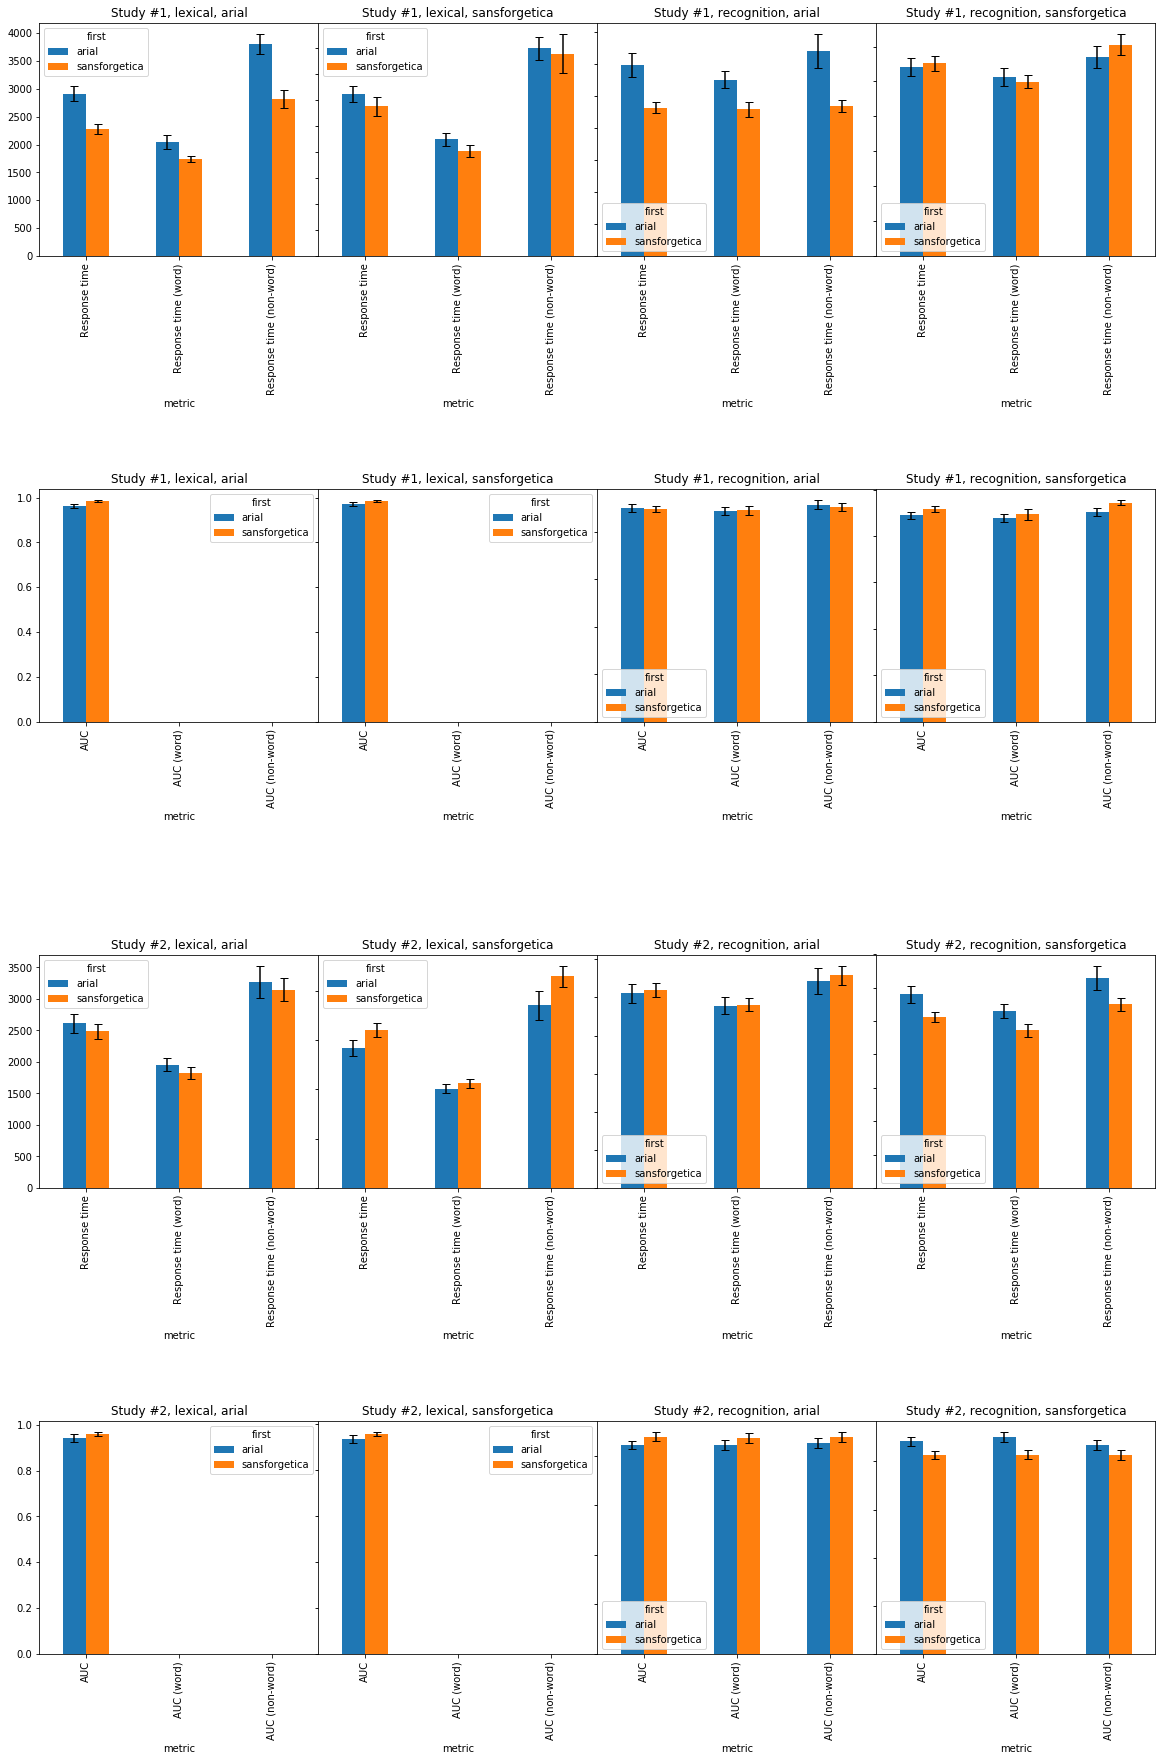

In [11]:
# comparison by first font - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-first-font.pdf")

# Training



JoM                                                        \
                  count       mean        std   min    25%   50%   75%    max   
Training                                                                        
Graphic designer   68.0  56.735294  21.291592  17.0  50.00  61.0  70.0  100.0   
Letter designer   100.0  55.160000  22.435866  10.0  34.00  59.0  75.0   90.0   
Non-designer      176.0  53.977273  20.943449   1.0  40.75  50.0  71.5   92.0   
Other designer     24.0  49.166667  22.371695  15.0  29.50  50.0  66.0   79.0   
Typographer        20.0  61.000000  17.222996  41.0  42.00  59.5  79.0   82.0   

                    JoL                                                         
                  count       mean        std   min    25%   50%    75%    max  
Training                                                                        
Graphic designer   68.0  66.911765  31.575891   0.0  50.00  75.0  100.0  100.0  
Letter designer   100.0  59.000000  32.473766   0.0  25.00  50.0  100.0  100.0  
Non-designer      176.0  69.886364  30.509739   0.0  50.00  75.0  100.0  100.0  
Other designer     24.0  62.500000  35.355339   0.0  43.75  50.0  100.0  100.0  
Typographer        20.0  65.000000  32.847334  25.0  25.00  62.5  100.0  100.0


# isDesigner



JoM                                                        \
            count       mean        std   min    25%   50%   75%    max   
isDesigner                                                                
False       176.0  53.977273  20.943449   1.0  40.75  50.0  71.5   92.0   
True        212.0  55.537736  21.664908  10.0  37.00  59.0  73.0  100.0   

              JoL                                                       
            count       mean        std  min   25%   50%    75%    max  
isDesigner                                                              
False       176.0  69.886364  30.509739  0.0  50.0  75.0  100.0  100.0  
True        212.0  62.500000  32.518679  0.0  25.0  50.0  100.0  100.0


# Font



JoM                                                      \
               count       mean        std  min   25%   50%   75%    max   
Font                                                                       
arial          194.0  56.711340  20.763139  1.0  47.0  59.0  73.0   92.0   
sansforgetica  194.0  52.948454  21.768148  7.0  35.0  50.0  71.0  100.0   

                 JoL                                                         
               count       mean        std   min   25%    50%    75%    max  
Font                                                                         
arial          194.0  90.463918  17.426121  25.0  75.0  100.0  100.0  100.0  
sansforgetica  194.0  41.237113  22.488119   0.0  25.0   50.0   50.0  100.0


# First font



JoM                                                       \
               count       mean        std   min   25%   50%   75%    max   
First font                                                                  
arial          200.0  55.380000  23.318541   1.0  38.0  59.0  75.0  100.0   
sansforgetica  188.0  54.244681  19.026964  14.0  41.0  50.0  70.0   90.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
First font                                                                 
arial          200.0  62.250000  33.530718  0.0  25.0  50.0  100.0  100.0  
sansforgetica  188.0  69.680851  29.449572  0.0  50.0  75.0  100.0  100.0


# Training



JoM                                                        \
                  count       mean        std   min    25%   50%   75%    max   
Training                                                                        
Graphic designer  100.0  52.240000  19.868822  15.0  38.00  50.0  65.0  100.0   
Letter designer    60.0  58.366667  16.681428  15.0  50.00  58.0  72.0   90.0   
Non-designer      184.0  51.369565  19.481653   6.0  37.75  50.0  68.5   86.0   
Other designer     48.0  53.083333  15.890360  19.0  47.50  50.0  60.0   85.0   
Typographer        28.0  59.000000  29.305542   5.0  50.00  55.5  90.0  100.0   

                    JoL                                                        
                  count       mean        std   min   25%   50%    75%    max  
Training                                                                       
Graphic designer  100.0  70.000000  30.151134  25.0  50.0  75.0  100.0  100.0  
Letter designer    60.0  54.166667  31.274708   0.0  25.0  50.0   75.0  100.0  
Non-designer      184.0  67.391304  33.620172   0.0  50.0  75.0  100.0  100.0  
Other designer     48.0  63.541667  32.599412   0.0  25.0  75.0  100.0  100.0  
Typographer        28.0  73.214286  22.493385  50.0  50.0  75.0  100.0  100.0


# isDesigner



JoM                                                         JoL  \
            count       mean        std  min    25%   50%   75%    max  count   
isDesigner                                                                      
False       184.0  51.369565  19.481653  6.0  37.75  50.0  68.5   86.0  184.0   
True        236.0  54.771186  19.851539  5.0  41.00  50.0  69.0  100.0  236.0   

                                                                 
                 mean        std  min   25%   50%    75%    max  
isDesigner                                                       
False       67.391304  33.620172  0.0  50.0  75.0  100.0  100.0  
True        65.042373  30.794416  0.0  25.0  75.0  100.0  100.0


# Font



JoM                                                       \
               count       mean        std  min   25%   50%    75%    max   
Font                                                                        
arial          210.0  53.280952  19.763001  5.0  40.0  50.0  68.75  100.0   
sansforgetica  210.0  53.280952  19.763001  5.0  40.0  50.0  68.75  100.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
Font                                                                       
arial          210.0  66.071429  32.083468  0.0  50.0  75.0  100.0  100.0  
sansforgetica  210.0  66.071429  32.083468  0.0  50.0  75.0  100.0  100.0


# First font



JoM                                                       \
               count       mean        std  min    25%   50%   75%    max   
First font                                                                  
arial          204.0  52.294118  19.973178  7.0  37.00  50.0  68.0  100.0   
sansforgetica  216.0  54.212963  19.516505  5.0  42.75  50.0  69.0  100.0   

                 JoL                                                       
               count       mean        std  min   25%   50%    75%    max  
First font                                                                 
arial          204.0  61.029412  33.027368  0.0  25.0  50.0  100.0  100.0  
sansforgetica  216.0  70.833333  30.404253  0.0  50.0  75.0  100.0  100.0

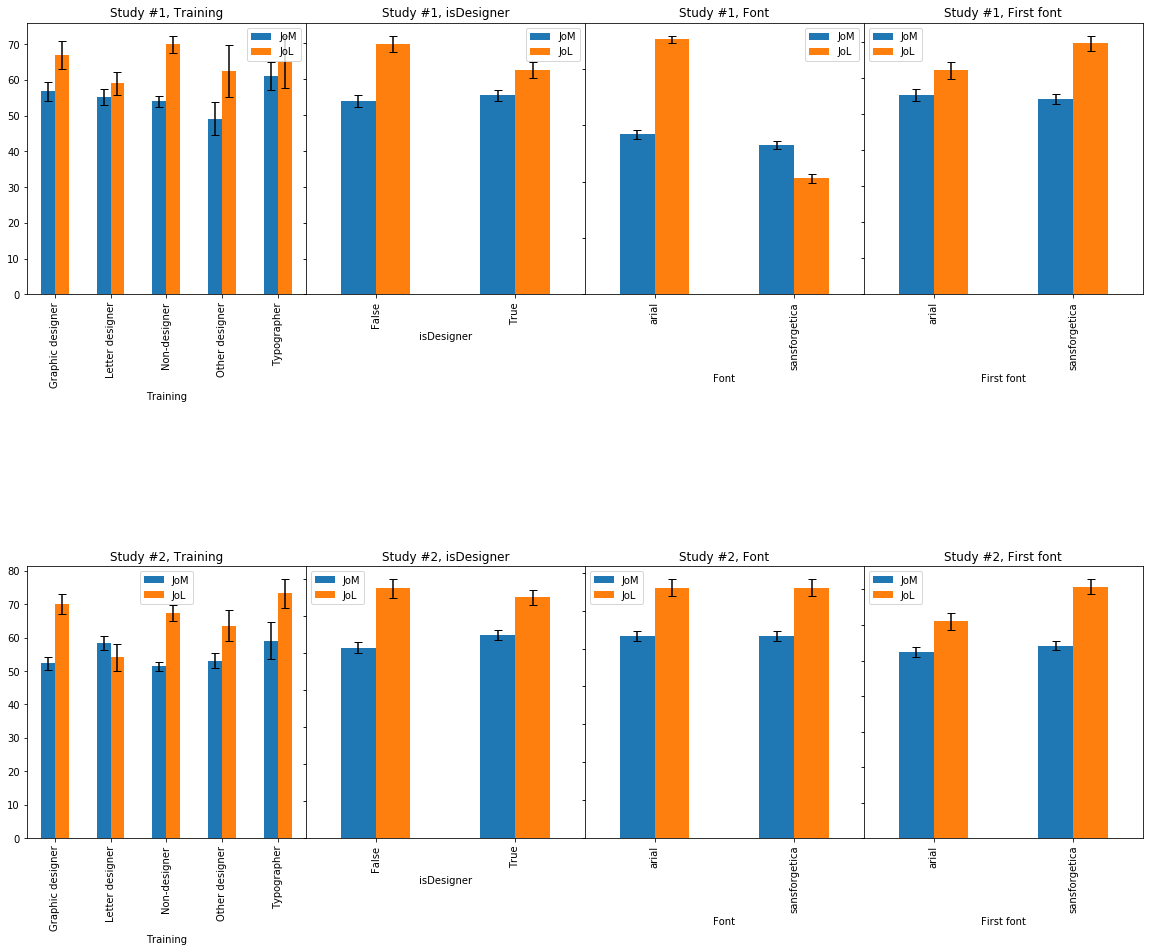

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
plt.subplots_adjust(wspace=0, hspace=1)
for sid in [1, 2]:
    for i, col in enumerate(["Training", "isDesigner", "Font", "First font"]):
        print("#", col)
        print()
        display(st[st["Study ID"] == sid].groupby([col])["JoM", "JoL"].describe())
        print()
        means = st[st["Study ID"] == sid].groupby([col])["JoM", "JoL"].mean()
        errors = st[st["Study ID"] == sid].groupby([col])["JoM", "JoL"].sem()
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[sid-1][i],
                       sharey=True,
                       title="Study #%d, %s" % (sid, col))
fig.savefig("results/JoM-JoL.pdf")

